# Analysis of 2009 songs

In [129]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
!pip install xgboost
import xgboost as xgb
!pip install plotnine
from plotnine import ggplot, aes, geom_point, geom_line, labs
!pip install pyreadr
import pyreadr

In [130]:
import importlib.metadata as metadata

print('numpy', metadata.version("numpy"))
print('pandas', metadata.version("pandas"))

numpy 1.24.3
pandas 2.0.3


In [131]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data processing

In [132]:
# Read data
data = pyreadr.read_r('song_data.rds') 
data = data[None]

In [133]:
#### Preliminary Checks ####
# Check genre composition over time
data['release_year'] = pd.to_datetime(data['release_date']).dt.year
# print(data['release_year'])
data_genres_composition = data.where(data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]))
data_genres_composition = data_genres_composition.dropna(how='all')
# print(data_genres_composition)

# display number of songs for each category for each year
data_genres_composition = data_genres_composition.groupby(['release_year', 'tag']).size().unstack().reset_index().astype(int)
display(data_genres_composition)

# display number of songs for each category and its proportion for each year
visu_data = data_genres_composition.copy()
data_genres_composition['sum'] = data_genres_composition['folk'] + data_genres_composition['hiphop'] + data_genres_composition['pop'] + data_genres_composition['rock']
data_genres_composition['folk_prop'] = data_genres_composition['folk'] / data_genres_composition['sum']
data_genres_composition['hiphop_prop'] = data_genres_composition['hiphop'] / data_genres_composition['sum']
data_genres_composition['pop_prop'] = data_genres_composition['pop'] / data_genres_composition['sum']
data_genres_composition['rock_prop'] = data_genres_composition['rock'] / data_genres_composition['sum']
display(data_genres_composition)

tag,release_year,folk,hiphop,pop,rock
0,2009,177,54,963,204
1,2010,140,137,1079,227
2,2011,279,113,1023,415
3,2012,289,271,1251,473
4,2013,438,314,1660,564
5,2014,802,804,2432,1211
6,2015,1297,918,2882,1687
7,2016,1072,849,3908,1447
8,2017,1775,2365,6497,2203
9,2018,1902,3636,9687,1940


tag,release_year,folk,hiphop,pop,rock,sum,folk_prop,hiphop_prop,pop_prop,rock_prop
0,2009,177,54,963,204,1398,0.126609,0.038627,0.688841,0.145923
1,2010,140,137,1079,227,1583,0.088440,0.086545,0.681617,0.143399
2,2011,279,113,1023,415,1830,0.152459,0.061749,0.559016,0.226776
3,2012,289,271,1251,473,2284,0.126532,0.118651,0.547723,0.207093
4,2013,438,314,1660,564,2976,0.147177,0.105511,0.557796,0.189516
5,2014,802,804,2432,1211,5249,0.152791,0.153172,0.463326,0.230711
6,2015,1297,918,2882,1687,6784,0.191185,0.135318,0.424823,0.248673
7,2016,1072,849,3908,1447,7276,0.147334,0.116685,0.537108,0.198873
8,2017,1775,2365,6497,2203,12840,0.138240,0.184190,0.505997,0.171573
9,2018,1902,3636,9687,1940,17165,0.110807,0.211826,0.564346,0.113021


## Data visualization

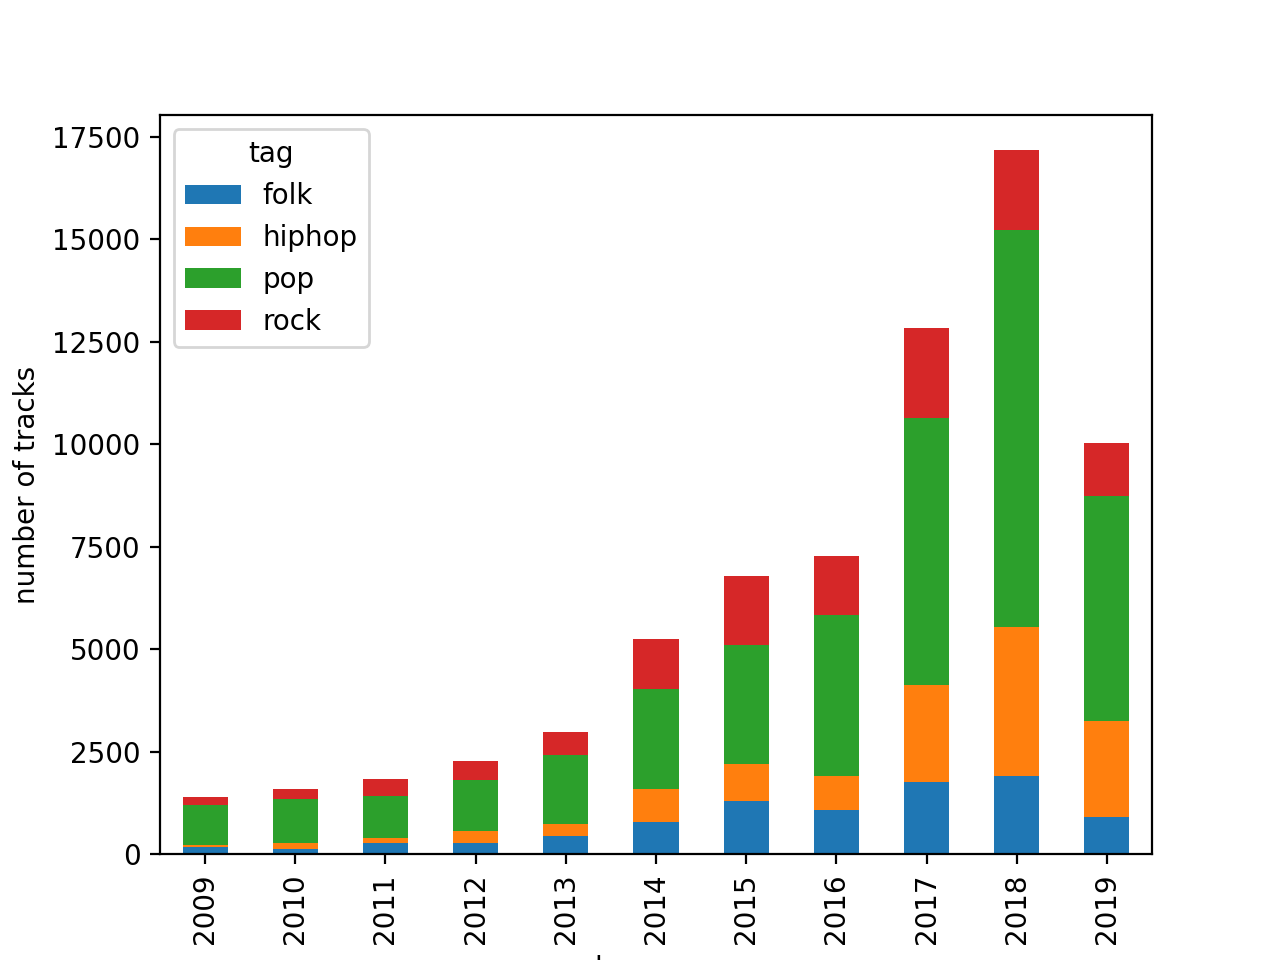

In [134]:
ax = visu_data.plot.bar(x='release_year', stacked=True)
plt.ylabel('number of tracks')
plt.show()

# Machine learning training set preparation

In [135]:
##### Picking training sets from early years: 2009 50 high profile songs for each genre #####

# ml_data = data[data['release_year'] == 2009].nlargest(50, 'listen_times') # 50 first most listened for each genre
ml_data = data[data['release_year'] == 2009]
# print(ml_data)

# Split data into train and test sets
ml_train, ml_test = train_test_split(ml_data, test_size=0.2, random_state=210016, shuffle=True)

# Select features for training and testing
ml_train = ml_train.iloc[:, [1] + list(range(6, 17))]
ml_test = ml_test.iloc[:, [1] + list(range(6, 17))]

y_true = ml_test['tag'].to_numpy()
y_true = np.unique(y_true, return_inverse=True)[1]

# Training classifiers

## Naive Bayes

In [136]:
nb_model = GaussianNB()
# fit data to model
nb_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
p_train = nb_model.predict(ml_train.iloc[:, 1:])
p_train_prob = nb_model.predict_proba(ml_train.iloc[:, 1:])
print('Mean on training set of NB ', round(np.mean(p_train == ml_train.iloc[:, 0]),3))

# predict proba from test
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
print('Mean on test set of NB', round(np.mean(p_test == ml_test.iloc[:, 0])),3)

# compute ROC AUC score of test set
print('AUC score of NB', round(roc_auc_score(y_true, p_test_prob, multi_class='ovr')),3)

Mean on training set 0.6082289803220036
Mean on test set 0.6285714285714286
AUC score 0.7539339972071808


## K-Nearest Neighbors

In [137]:
# # Use AUC to find the best k: 31
# # Init dataframe and columns
# df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
# for k in range(1, 41):
#     #print(k)
#     knn_model = KNeighborsClassifier(n_neighbors=k)
#     knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
#     knn_model_prob = knn_model.predict_proba(ml_test.iloc[:, 1:])
#     y_pred_lab = knn_model.predict(ml_test.iloc[:, 1:])
#     acc = np.mean(y_pred_lab == ml_test.iloc[:, 0])
#     auc = roc_auc_score(y_true, knn_model_prob, multi_class='ovr')
#     # df_knn_auc = df_knn_auc.append({'k': k, 'acc': acc, 'auc': auc}, ignore_index=True)
#     df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
# df_knn_auc = df_knn_auc.sort_values(by='acc', ascending=False)
# display(df_knn_auc.head())

df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
for k in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
    knn_pred = knn_model.predict(ml_test.iloc[:, 1:])
    acc = sum(knn_pred == ml_test.iloc[:, 0]) / len(knn_pred)
    auc = roc_auc_score(ml_test.iloc[:, 0], knn_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
    print(k)
df_knn_auc = df_knn_auc.sort_values(['acc','auc'], ascending=[False,False]).head(10)
print('KNN AUC score :\n', df_knn_auc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
KNN AUC score :     k       acc       auc
0   9  0.760714  0.812217
0   8  0.757143  0.806108
0  11  0.757143  0.805675
0  16  0.753571  0.800327
0  17  0.753571  0.798068
0   6  0.753571  0.783771
0  12  0.750000  0.810317
0  18  0.750000  0.796110
0  14  0.746429  0.801806
0  15  0.742857  0.806074


## Random Forest

In [138]:
# init dataframe and columns
df_rf_auc = pd.DataFrame(columns=['n', 'max', 'acc', 'auc'])
for n in range(20, 41):
    for max in range(20, 41):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
        rf_model_prob = rf_model.predict_proba(ml_test.iloc[:, 1:])
        acc = np.mean(rf_model.predict(ml_test.iloc[:, 1:]) == ml_test.iloc[:, 0])
        auc = roc_auc_score(y_true, rf_model_prob, multi_class='ovr')
        # df_rf_auc = df_rf_auc.append({'n': n, 'max': max, 'acc': acc, 'auc': auc}, ignore_index=True)
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame.from_records([{'n': n, 'max': max, 'acc': acc, 'auc': auc}])])
        print('depth :',max)
    print('n :',n)
df_rf_auc = df_rf_auc.sort_values(by='acc', ascending=False)
display(df_rf_auc.head())

depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 20
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 21
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 22
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 23
depth : 20
depth : 21
depth : 22
depth : 23
dept

,n,max,acc,auc
0,24,37,0.775000,0.815714
0,31,33,0.771429,0.800956
0,38,35,0.771429,0.810992
0,25,39,0.771429,0.811654
0,28,35,0.771429,0.802656


## XGBoost

In [139]:
ml_train_num = ml_train.copy()
ml_train_num['tag'] = ml_train_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
ml_test_num = ml_test.copy()
ml_test_num['tag'] = ml_test_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num.iloc[:, 0])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num.iloc[:, 0])
best_param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 4}
best_seednumber = 1234
best_logloss = float('inf')
best_logloss_index = 0
print('training')
# train on 10 epochs
for iter in range(1, 11):
    print('epoch',iter)
    param = best_param.copy()
    param['max_depth'] = np.random.randint(2, 6)
    param['eta'] = np.random.uniform(0.01, 0.3)
    seed_number=np.random.randint(10000)
    cv_result = xgb.cv(params=param, dtrain=train_matrix, num_boost_round=1000, nfold=5, early_stopping_rounds=8, seed=seed_number)
    min_logloss = cv_result['test-mlogloss-mean'].min()
    min_logloss_index = cv_result['test-mlogloss-mean'].idxmin()
    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
    
nround = best_logloss_index
bst_model = xgb.train(params=best_param, dtrain=train_matrix, num_boost_round=nround)
# Predict hold-out test set
test_pred = bst_model.predict(test_matrix)
test_prediction = pd.DataFrame(test_pred).apply(lambda x: np.argmax(x), axis=1)
print('Mean on test set with XGB boost is', round(np.mean(test_prediction.to_numpy() == ml_test_num.iloc[:, 0].to_numpy())),3)
print('AOC score on test set with XGB boost is', round(roc_auc_score(y_true, test_pred, multi_class='ovr')),3)

training
epoch 1


epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Mean on test set with XGB boost is 0.7285714285714285
AOC score on test set with XGB boost is 0.5120112342616698


# Prediction

In [143]:
data_predict = data[data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])]
data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date'], format="%Y%m%d%H%M%S").dt.year
data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['treatment_date'] = (pd.to_datetime(data_predict['release_date']) < pd.to_datetime('2017-06-24'))
data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
print(data_predict.head())
# data_predict = data[data['release_year'].isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
# data_predict['release_year'] = pd.to_datetime(data_predict['release_date']).dt.year
# data_predict['tag_bin'] = data_predict['tag'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
# data_predict['treatment_date'] = (pd.to_datetime(data_predict['release_date']) < pd.to_datetime('2017-04-16'))
# data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
# print(data_predict.head())
# x_data_predict = data_predict.iloc[:, 6:17]


        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

/tmp/ipykernel_14629/2030733037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/2030733037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/2030733037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Naive Bayes

In [144]:
data_predict.loc[:,'gnb_pred'] = nb_model.predict(data_predict.iloc[:, 6:17])
data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
data_predict.loc[:,'gnb_pred_bin'] = np.where(data_predict['gnb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'gnb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['gnb_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

/tmp/ipykernel_14629/2541280749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/2541280749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/2541280749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/2

## K-Nearest Neighbors

In [145]:
data_predict['knn_pred'] = knn_model.predict(data_predict.iloc[:, 6:17])
data_predict['knn_pred_acc'] = (data_predict['knn_pred'] == data_predict['tag']).astype(int)
data_predict['knn_pred_bin'] = np.where(data_predict['knn_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['knn_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['knn_pred_bin']).astype(int)
data_predict = data_predict.dropna(how='all')
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

/tmp/ipykernel_14629/3649426615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/3649426615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/3649426615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_14629/3

## Random Forest

In [146]:
data_predict['rf_pred'] = rf_model.predict(data_predict.iloc[:, 6:17])
data_predict['rf_pred_acc'] = data_predict['rf_pred'] == data_predict['tag']
data_predict['rf_pred_bin'] = np.where(data_predict['rf_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['rf_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['rf_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

## XGBoost

In [147]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(data_predict.iloc[:, 6:17]))
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: np.argmax(x) + 1, axis=1)
data_predict['xgb_pred_acc'] = data_predict['xgb_pred'] == data_predict['tag']
data_predict['xgb_pred_bin'] = np.where(data_predict['xgb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['xgb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['xgb_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

In [148]:
# print(data_predict)
print(data_predict.columns)
data_predict.to_pickle('pickles/data_predict_2009.pkl')

Index(['song_id', 'tag', 'release_date', 'release_month', 'release_year',
       'listen_times', 'chroma_stft_norm', 'rmse_norm',
       'spectral_centroid_norm', 'spectral_bandwidth_norm', 'rolloff_norm',
       'zero_crossing_rate_norm', 'mfcc1_norm', 'mfcc2_norm', 'mfcc3_norm',
       'mfcc4_norm', 'mfcc5_norm', 'mfcc6_norm', 'mfcc7_norm', 'mfcc8_norm',
       'mfcc9_norm', 'mfcc10_norm', 'mfcc11_norm', 'mfcc12_norm',
       'mfcc13_norm', 'mfcc14_norm', 'mfcc15_norm', 'mfcc16_norm',
       'mfcc17_norm', 'mfcc18_norm', 'mfcc19_norm', 'mfcc20_norm', 'tag_bin',
       'treatment_date', 'treatment_year', 'gnb_pred', 'gnb_pred_acc',
       'gnb_pred_bin', 'gnb_pred_bin_acc', 'knn_pred', 'knn_pred_acc',
       'knn_pred_bin', 'knn_pred_bin_acc', 'rf_pred', 'rf_pred_acc',
       'rf_pred_bin', 'rf_pred_bin_acc', 'xgb_pred', 'xgb_pred_acc',
       'xgb_pred_bin', 'xgb_pred_bin_acc'],
      dtype='object')


# Metrics

## Naive Bayes

In [149]:
gnb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
gnb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
gnb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
gnb_precision_tbyyear    = data_predict.copy()[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics.head())
print(gnb_metrics.columns)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(gnb_metrics.head())

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,1,0.612303,0.949928,0.351852,0.351852
1,2010,1,0.540745,0.890082,0.087591,0.196721
2,2011,1,0.468852,0.902732,0.088496,0.117647
3,2012,1,0.492995,0.863398,0.118081,0.304762
4,2013,1,0.484879,0.878696,0.105096,0.292035


Index(['release_year', 'treatment_year', 'gnb_pred_acc', 'gnb_pred_bin_acc',
       'gnb_recall', 'gnb_precision'],
      dtype='object')


,release_year,treatment_year,metrics,values
0,2009,1,gnb_pred_acc,0.612303
1,2010,1,gnb_pred_acc,0.540745
2,2011,1,gnb_pred_acc,0.468852
3,2012,1,gnb_pred_acc,0.492995
4,2013,1,gnb_pred_acc,0.484879


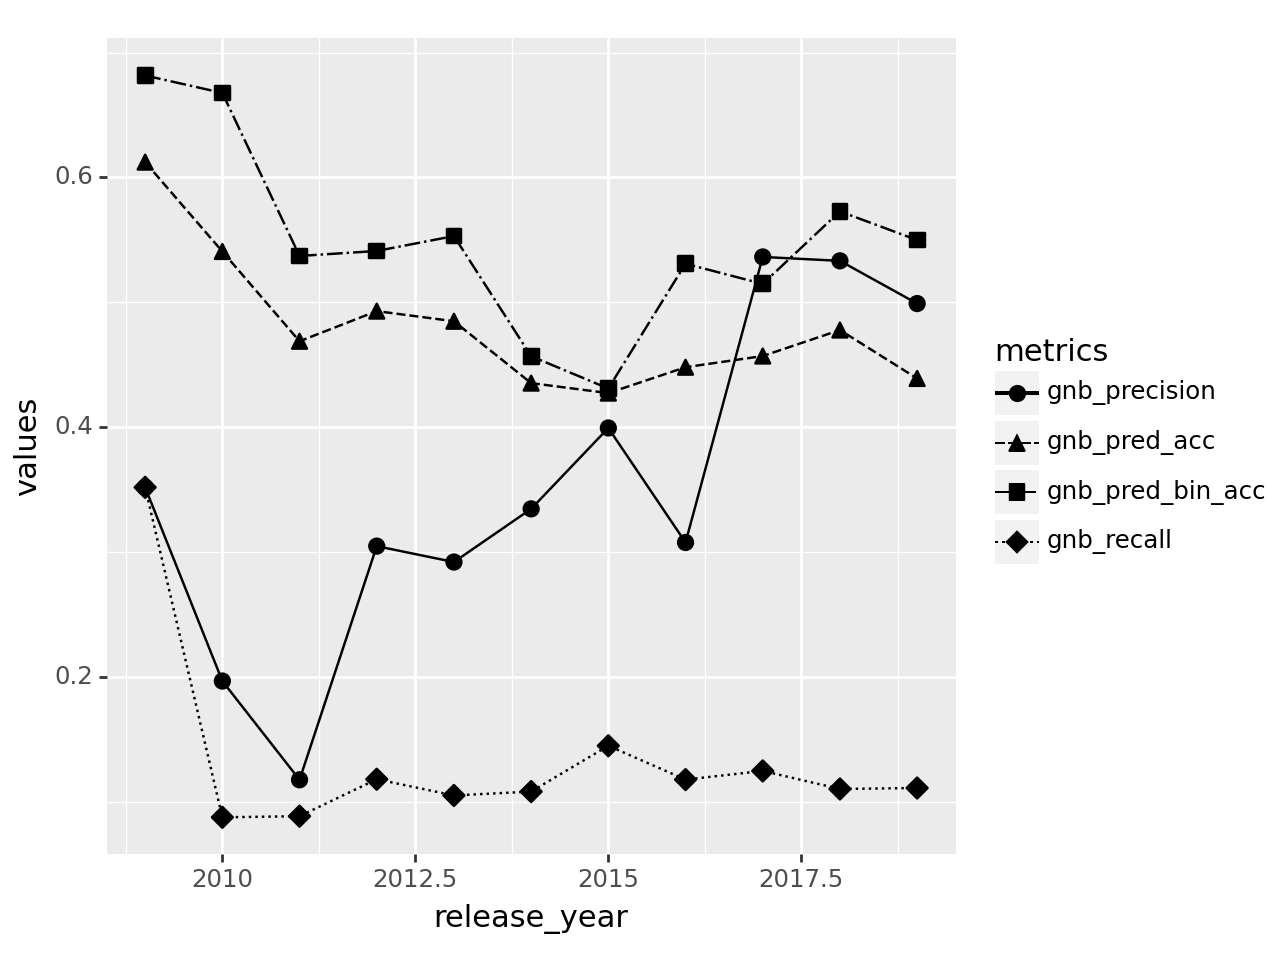

In [ ]:
# plot results
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Naive Bayes") + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_2009.pkl')

## K-Nearest Neighbors

   release_year  treatment_year  knn_pred_acc
0          2009               1      0.743205
1          2010               1      0.677195
2          2011               1      0.567760
3          2012               1      0.565236
4          2013               1      0.566532
   release_year  treatment_year  knn_pred_bin_acc
0          2009               1          0.962089
1          2010               1          0.914087
2          2011               1          0.937705
3          2012               1          0.881349
4          2013               1          0.894825


,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,1,0.743205,0.962089,0.018519,1.0
1,2010,1,0.677195,0.914087,0.007299,1.0
2,2011,1,0.567760,0.937705,0.000000,0.0
3,2012,1,0.565236,0.881349,0.003690,0.5
4,2013,1,0.566532,0.894825,0.003185,1.0


,release_year,treatment_year,metrics,values
0,2009,1,knn_pred_acc,0.743205
1,2010,1,knn_pred_acc,0.677195
2,2011,1,knn_pred_acc,0.567760
3,2012,1,knn_pred_acc,0.565236
4,2013,1,knn_pred_acc,0.566532


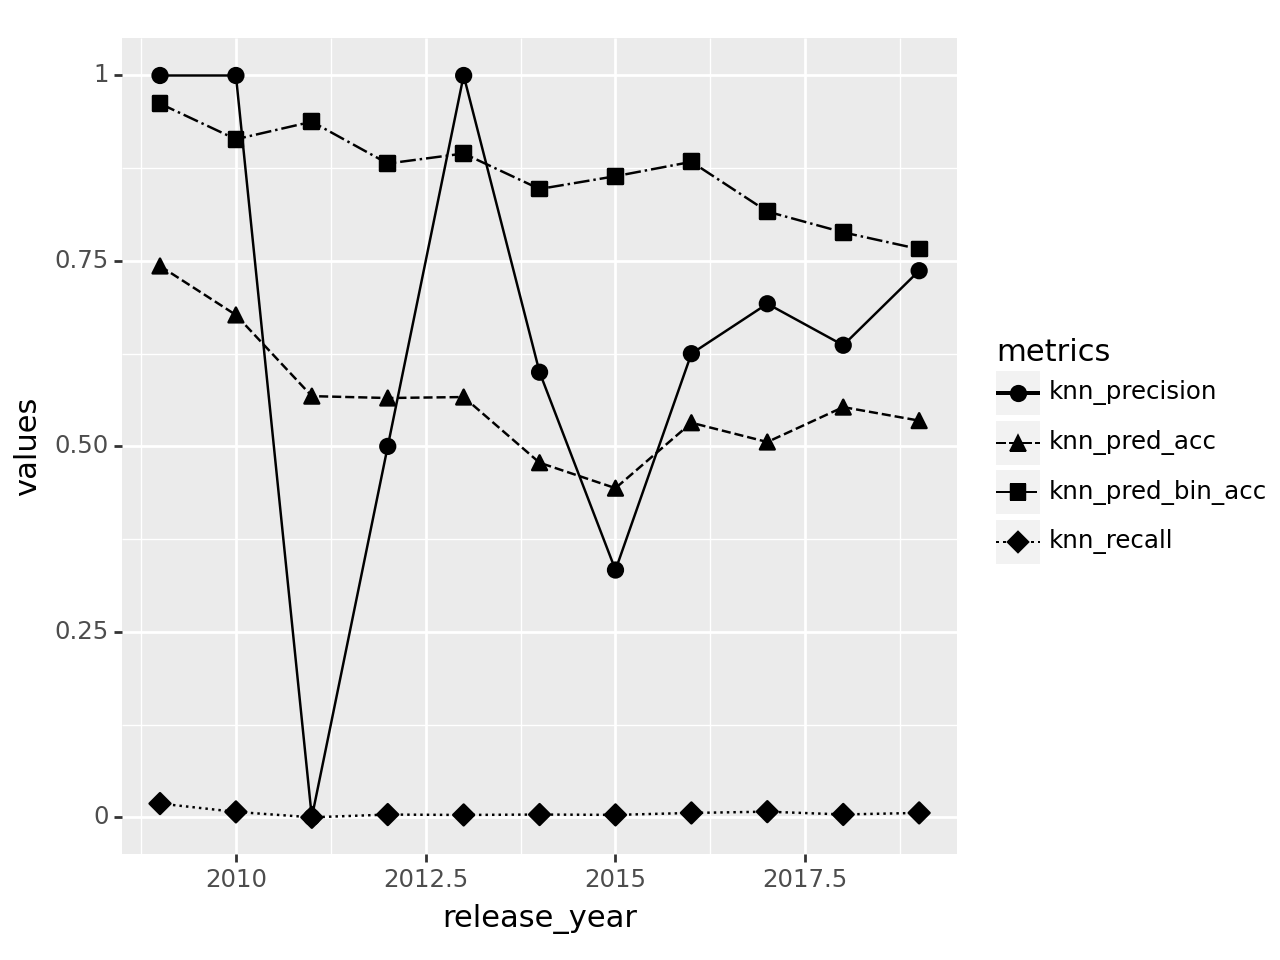

In [155]:
knn_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
print(knn_mean_acc_tbyyear.head())
knn_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
print(knn_mean_bin_acc_tbyyear.head())
# print(data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index())

knn_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
# print(knn_recall_tbyyear)

knn_precision_tbyyear = data_predict[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics.head())

knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(knn_metrics.head())

# plot results
knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="KNN") + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_2009.pkl')

# # precision and recall have values problems 


## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,1,0.942060,0.991416,0.796296,0.977273
1,2010,1,0.673405,0.915351,0.080292,0.578947
2,2011,1,0.566120,0.932240,0.044248,0.238095
3,2012,1,0.574431,0.882662,0.070111,0.542857
4,2013,1,0.562836,0.898185,0.092357,0.617021
5,2014,1,0.487331,0.852162,0.060945,0.700000
6,2015,1,0.455926,0.867040,0.075163,0.565574
7,2016,1,0.526388,0.882903,0.068316,0.487395
8,2017,0,0.513474,0.826246,0.084989,0.750000
9,2018,0,0.554908,0.802039,0.094059,0.766816


,release_year,treatment_year,metrics,values
0,2009,1,rf_pred_acc,0.942060
1,2010,1,rf_pred_acc,0.673405
2,2011,1,rf_pred_acc,0.566120
3,2012,1,rf_pred_acc,0.574431
4,2013,1,rf_pred_acc,0.562836
5,2014,1,rf_pred_acc,0.487331
6,2015,1,rf_pred_acc,0.455926
7,2016,1,rf_pred_acc,0.526388
8,2017,0,rf_pred_acc,0.513474
9,2018,0,rf_pred_acc,0.554908


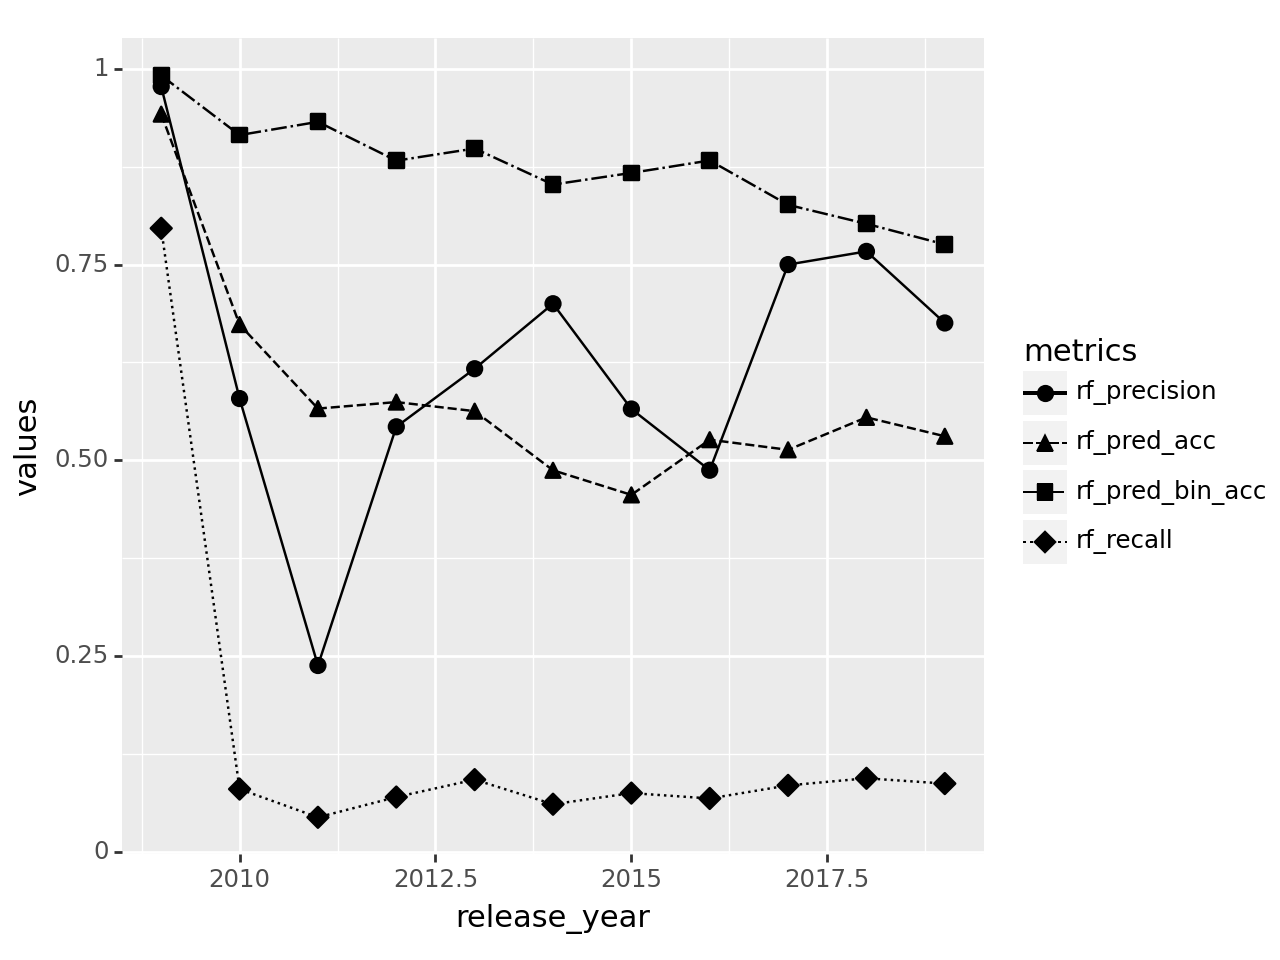

In [151]:
rf_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
rf_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
rf_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
rf_precision_tbyyear    = data_predict.copy()[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(rf_metrics)

rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Random Forest") + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_2009.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,1,0.0,0.961373,0.0,NaN
1,2010,1,0.0,0.913455,0.0,NaN
2,2011,1,0.0,0.938251,0.0,NaN
3,2012,1,0.0,0.881349,0.0,NaN
4,2013,1,0.0,0.894489,0.0,NaN


,release_year,treatment_year,metrics,values
0,2009,1,xgb_pred_acc,0.0
1,2010,1,xgb_pred_acc,0.0
2,2011,1,xgb_pred_acc,0.0
3,2012,1,xgb_pred_acc,0.0
4,2013,1,xgb_pred_acc,0.0


/home/mhelias004/Downloads/ls/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/home/mhelias004/Downloads/ls/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


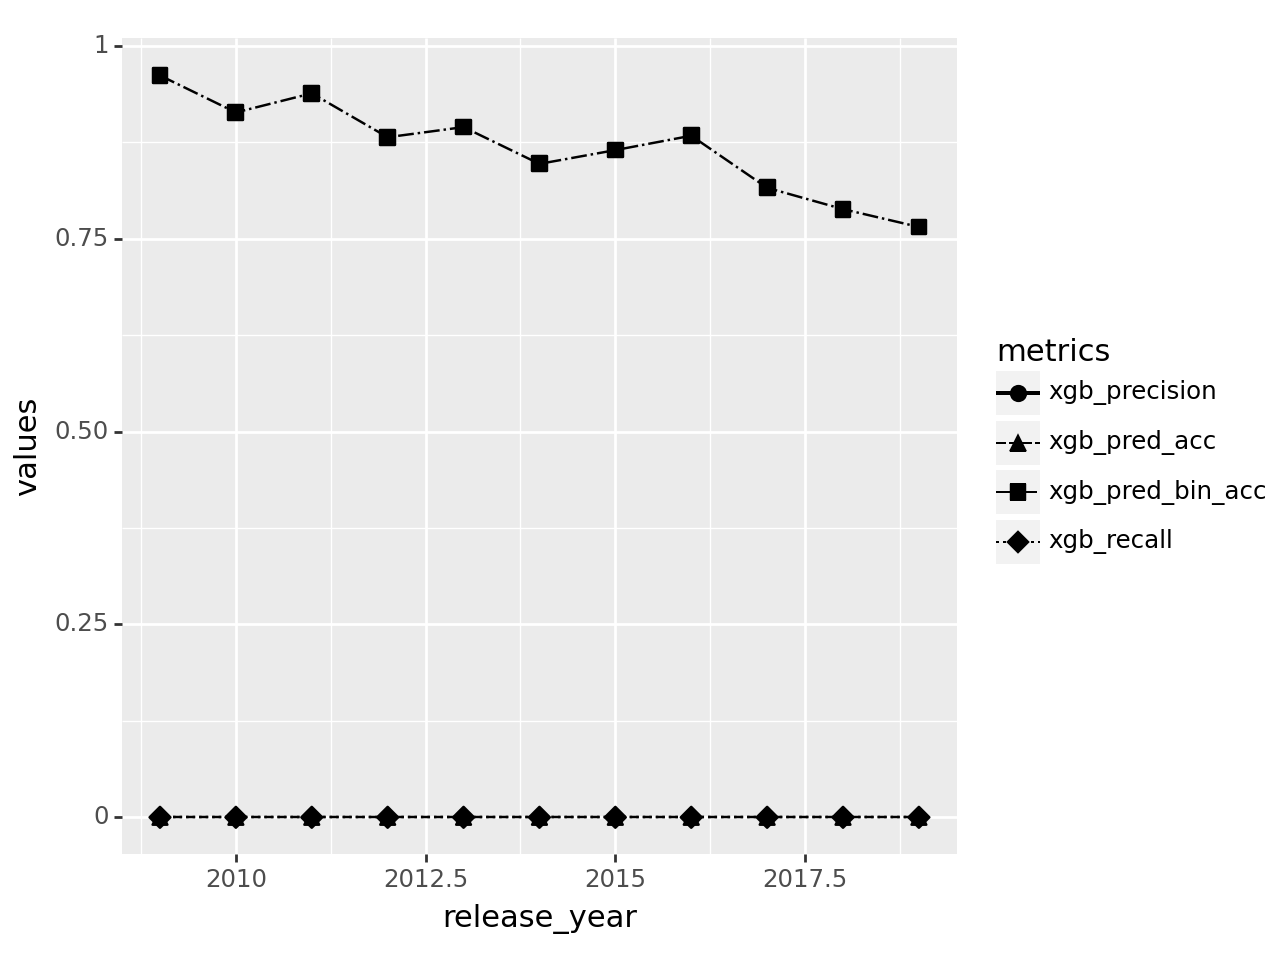

In [152]:
xgb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
xgb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
xgb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
xgb_precision_tbyyear    = data_predict.copy()[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics.head())
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(xgb_metrics.head())

xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="XGBoost") + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_2009.pkl')

## Total

,release_year,treatment_year,metrics,values
0,2009,1,classifiers_pred_acc,0.574392
1,2010,1,classifiers_pred_acc,0.472836
2,2011,1,classifiers_pred_acc,0.400683
3,2012,1,classifiers_pred_acc,0.408165
4,2013,1,classifiers_pred_acc,0.403562
5,2014,1,classifiers_pred_acc,0.350162
6,2015,1,classifiers_pred_acc,0.331736
7,2016,1,classifiers_pred_acc,0.376581
8,2017,0,classifiers_pred_acc,0.369100
9,2018,0,classifiers_pred_acc,0.396432


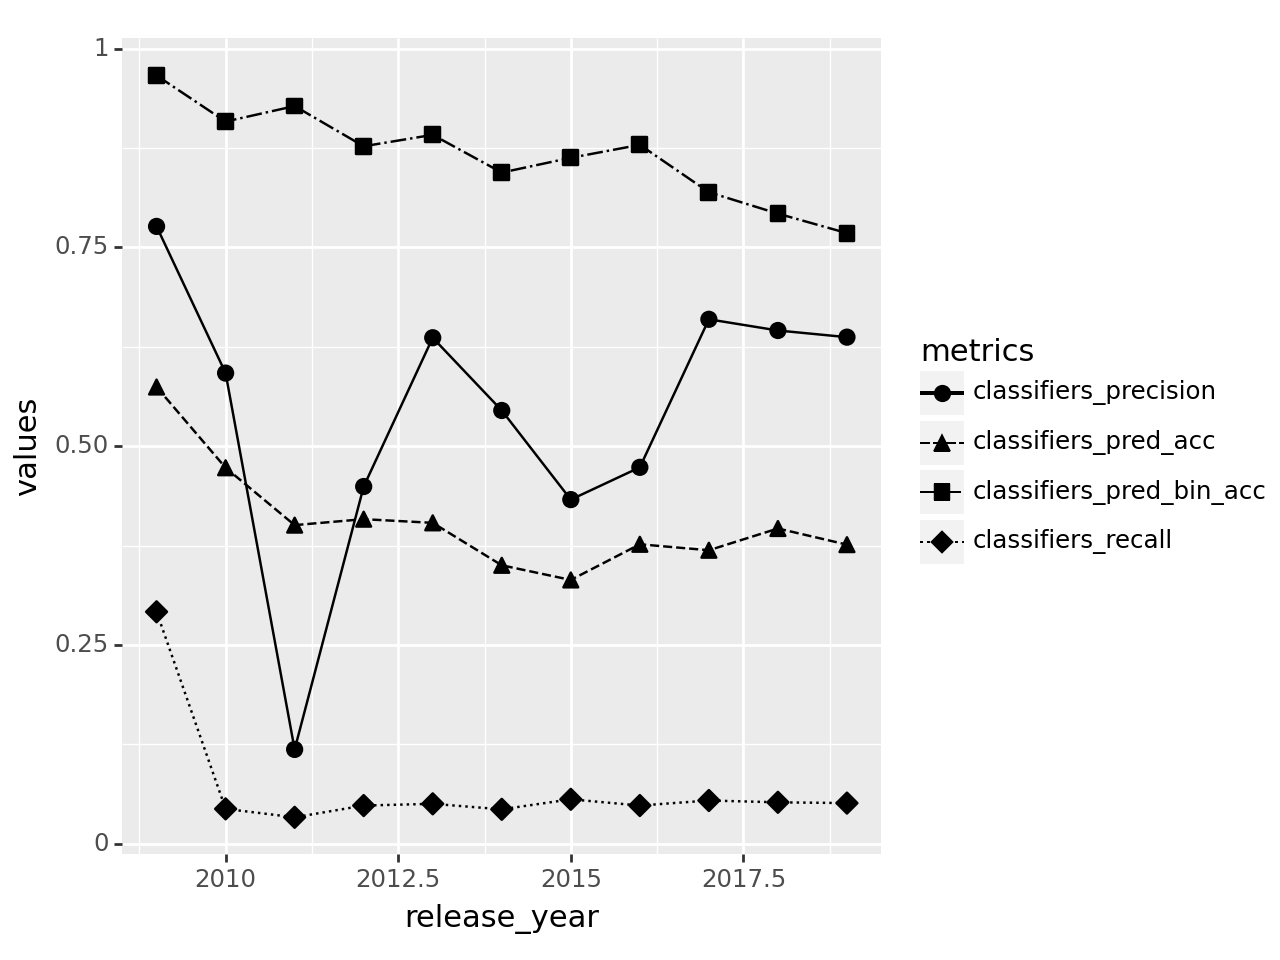

In [153]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_2009.pkl')
display(average)

average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Average") + geom_line(aes(linetype='metrics'))
print(average_plot)